## Combine CNNs and Naive Bayes predictions

In [34]:
import pandas as pd
import numpy as np
from sklearn.isotonic import IsotonicRegression
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

In [46]:
# dropout or full image 
USE_DROPOUT = True

if not USE_DROPOUT:
    # CNN (calibrated) on combination splits
    CNN_TEST_PATH = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/cnn_comb_test_calibrated_predictions.csv"
    CNN_VAL_PATH  = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/cnn_comb_train_calibrated_predictions.csv"
    # BLR (no calibration) on combination splits
    NB_TEST_PATH  = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/blr_full_comb_test_predictions.csv"
    NB_VAL_PATH   = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/blr_full_comb_train_predictions.csv"
else:
    CNN_TEST_PATH = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/cnn_dropout_comb_test_calibrated_predictions.csv"
    CNN_VAL_PATH  = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/cnn_dropout_comb_train_calibrated_predictions.csv"
    NB_TEST_PATH  = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/blr_dropout_comb_test_predictions.csv"
    NB_VAL_PATH   = "/Users/ioannaioannidou/Desktop/Uppsala University/Year 2/Semester 1/Project in DS/blr_dropout_comb_train_predictions.csv"


In [47]:
# Standardise dfs so merging will be easier 
def standardise_df(df, want_prefix, current_true_label_col=None):
    df = df.copy()
    # id column 
    if "id" not in df.columns:
        df.insert(0, "id", np.arange(len(df)))

    # true_label column
    if "true_label" not in df.columns:
        cand = current_true_label_col if current_true_label_col else ("label" if "label" in df.columns else None)
        if cand is not None:
            df = df.rename(columns={cand: "true_label"})
        else:
            pass

    # find prob columns 
    prob_cols = [c for c in df.columns if "_class_" in c]
    def _cls_idx(c):
        try:
            return int(c.split("_")[-1])
        except:
            return 0
    prob_cols = sorted(prob_cols, key=_cls_idx)

    # rename to the expected prefix 
    rename_map = {c: f"{want_prefix}_class_{_cls_idx(c)}" for c in prob_cols}
    df = df.rename(columns=rename_map)

    return df

1. Accurate Probability Calibration for Multiple Classifiers by Leon Wenliang Zhong and James T. Kwok

In their paper they use soft voting (averaging the probabilities) to get an ensemble starting point for each class. Then they fit an isotonic regression to make the combined probability well-calibrated and finally optimise using alternating direction method of multipliers (ADMM). 

I will try to replicate their method and see if it improves the accuracy. (exact steps on the paper page 1942)

In [48]:
# TEST DATASET 
# Calibrated preds of cnn 
cnn_preds_test = pd.read_csv(CNN_TEST_PATH)
# standardize CNN columns to cnn_class_k + ensure id/true_label exist
cnn_preds_test = standardise_df(cnn_preds_test, want_prefix="cnn")

cnn_preds_test.head()

# The predictions for the Naive Bayes classifier are currently not calibrated - I use it as is just to test my part. 
# Once we have the calibrated preds we can change them.
nb_preds_test = pd.read_csv(NB_TEST_PATH)

# BLR files usually have 'label' and no 'id'
nb_preds_test = standardise_df(nb_preds_test, want_prefix="nb")
nb_preds_test.head()

# Merge the two datasets
cnn_nb_combined_test = cnn_preds_test.merge(nb_preds_test, on="id")

# Get the probs for the CNN and NB
cnn_probs_test = cnn_nb_combined_test[[f"cnn_class_{i}" for i in range(10)]].values
nb_probs_test  = cnn_nb_combined_test[[f"nb_class_{i}"  for i in range(10)]].values

# Sanity checks 
# Check if probs sum to 1 for the CNN and NB
cnn_sum = cnn_nb_combined_test[[f"cnn_class_{i}" for i in range(10)]].sum(axis=1)
print(cnn_sum)

nb_sum = cnn_nb_combined_test[[f"nb_class_{i}" for i in range(10)]].sum(axis=1)
print(nb_sum)

# Calculate the average prob between CNN and NB 
avg_probs_test = 0.5 * cnn_probs_test + 0.5 * nb_probs_test

# Get the highest (final prediction)
avg_preds_test = np.argmax(avg_probs_test, axis=1)
# both frames have 'true_label' 
y_true_test = cnn_nb_combined_test["true_label_y"].values

# Get the accuracy 
accuracy = (avg_preds_test == y_true_test).mean() * 100
print(f"Accuracy Test (average): {accuracy}%")


0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
9995    1.0
9996    1.0
9997    1.0
9998    1.0
9999    1.0
Length: 10000, dtype: float64
0       1.0
1       1.0
2       1.0
3       1.0
4       1.0
       ... 
9995    1.0
9996    1.0
9997    1.0
9998    1.0
9999    1.0
Length: 10000, dtype: float64
Accuracy Test (average): 87.99%


In [49]:
# VALIDATION DATASET
# Validation preds of CNN and NB
cnn_preds_val = pd.read_csv(CNN_VAL_PATH)
cnn_preds_val = standardise_df(cnn_preds_val, want_prefix="cnn")
cnn_preds_val.head()

nb_preds_val = pd.read_csv(NB_VAL_PATH)
nb_preds_val = standardise_df(nb_preds_val, want_prefix="nb")
nb_preds_val.head()

# Merge the two datasets 
cnn_nb_combined_val = cnn_preds_val.merge(nb_preds_val, on="id")

# Get the probs for the CNN and NB
cnn_probs_val = cnn_nb_combined_val[[f"cnn_class_{i}" for i in range(10)]].values
nb_probs_val  = cnn_nb_combined_val[[f"nb_class_{i}"  for i in range(10)]].values

y_true_val = cnn_nb_combined_val["true_label_y"].values

# Repeat for validation
avg_probs_val = 0.5 * cnn_probs_val + 0.5 * nb_probs_val
avg_preds_val = np.argmax(avg_probs_val, axis=1)

accuracy_val = (avg_preds_val == y_true_val).mean() * 100
print(f"Accuracy Val (average): {accuracy_val}%")


Accuracy Val (average): 82.57083333333334%


In [50]:
from sklearn.metrics import log_loss

# Calculate NLL and ECE for validation and testing set 
nll_val = log_loss(y_true_val, avg_probs_val, labels=np.arange(10))
print(f"NLL Val (average): {nll_val}")

nll_test = log_loss(y_true_test, avg_probs_test, labels=np.arange(10))
print(f"NLL Test (average): {nll_test}")


def ece_score(probs, labels, n_bins=15):
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    accuracies = (predictions == labels)

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        mask = (confidences > bins[i]) & (confidences <= bins[i+1])
        if mask.any():
            bin_acc = accuracies[mask].mean()
            bin_conf = confidences[mask].mean()
            ece += np.abs(bin_acc - bin_conf) * mask.mean()
    return ece

ece_val = ece_score(avg_probs_val, y_true_val)
print(f"ECE Val (average): {ece_val}")

ece_test = ece_score(avg_probs_test, y_true_test)
print(f"ECE Test (average): {ece_test}")


NLL Val (average): 0.5493837147035744
NLL Test (average): 0.4618148672918114
ECE Val (average): 0.13201211005939265
ECE Test (average): 0.1548269563083668


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [51]:
# All results for simple average (50/50)
print(f"Accuracy Test (average): {accuracy}%")
print(f"Accuracy Val (average): {accuracy_val}%")
print()
print(f"NLL Val (average): {nll_val}")
print(f"NLL Test (average): {nll_test}")
print()
print(f"ECE Val (average): {ece_val}")
print(f"ECE Test (average): {ece_test}")
print()

Accuracy Test (average): 87.99%
Accuracy Val (average): 82.57083333333334%

NLL Val (average): 0.5493837147035744
NLL Test (average): 0.4618148672918114

ECE Val (average): 0.13201211005939265
ECE Test (average): 0.1548269563083668



In [41]:
# Weighted Average using AUC (macro one-vs-rest) - Eq 7 from the paper 
from sklearn.metrics import roc_auc_score

auc_cnn = roc_auc_score(y_true_val, cnn_probs_val, multi_class="ovr", average='macro')
auc_nb  = roc_auc_score(y_true_val, nb_probs_val,  multi_class="ovr", average='macro')

print(f"AUC CNN Val: {auc_cnn}  and  AUC NB Val: {auc_nb}")

# Calculate eta (Eq 7)
# μ is the average of (1 − AUCc) over the C classifiers
# (fixed the parenthesis bug so it's truly an average)
m = ((1 - auc_cnn) + (1 - auc_nb)) / 2.0

# η_c ∝ exp( - (1 - AUC_c) / (2 μ) )  → then normalize to sum to 1
eta_cnn_unnorm = np.exp(-(1 - auc_cnn) / (2.0 * m))
eta_nb_unnorm  = np.exp(-(1 - auc_nb)  / (2.0 * m))

# Z normalizes {ηc}Cc=1 to sum to 1
Z = eta_cnn_unnorm + eta_nb_unnorm

eta_cnn = eta_cnn_unnorm / Z
eta_nb  = eta_nb_unnorm  / Z

print(f"Eta (weights) for CNN: {eta_cnn} and NB: {eta_nb}")

# Use the weights to calculate a new wgt avg and pick the highest 
wgt_avg_probs_val  = eta_cnn * cnn_probs_val + eta_nb * nb_probs_val
wgt_avg_preds_val  = np.argmax(wgt_avg_probs_val, axis=1)

wgt_avg_probs_test = eta_cnn * cnn_probs_test + eta_nb * nb_probs_test
wgt_avg_preds_test = np.argmax(wgt_avg_probs_test, axis=1)

# Calculate the metrics for wgt_val
acc_wgt_avg_val  = (wgt_avg_preds_val  == y_true_val).mean() * 100
nll_wgt_avg_val  = log_loss(y_true_val,  wgt_avg_probs_val,  labels=np.arange(10))
ece_wgt_avg_val  = ece_score(wgt_avg_probs_val,  y_true_val)

# Calculate the metrics for wgt_test
acc_wgt_avg_test = (wgt_avg_preds_test == y_true_test).mean() * 100
nll_wgt_avg_test = log_loss(y_true_test, wgt_avg_probs_test, labels=np.arange(10))
ece_wgt_avg_test = ece_score(wgt_avg_probs_test, y_true_test)



AUC CNN Val: 0.49764764043060455  and  AUC NB Val: 0.9480013351125909
Eta (weights) for CNN: 0.30737972002692104 and NB: 0.692620279973079


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:259: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [42]:
# All results for weighted average
print(f"Accuracy Test (Weighted Average): {acc_wgt_avg_test}%")
print(f"Accuracy Val (Weighted Average): {acc_wgt_avg_val}%")
print()
print(f"NLL Val (Weighted Average): {nll_wgt_avg_val}")
print(f"NLL Test (Weighted Average): {nll_wgt_avg_test}")
print()
print(f"ECE Val (Weighted Average): {ece_wgt_avg_val}")
print(f"ECE Test (Weighted Average): {ece_wgt_avg_test}")
print()

Accuracy Test (Weighted Average): 51.0%
Accuracy Val (Weighted Average): 49.25%

NLL Val (Weighted Average): 1.1009019180161665
NLL Test (Weighted Average): 1.0866268132190433

ECE Val (Weighted Average): 0.16638633042828532
ECE Test (Weighted Average): 0.16837222955582068



In [ ]:
# Multi-Isotonic Calibration Model (MIC)

#  MIC constraints (soft voting) Eq 2 (paper)

# DAG Eq 3 (paper) ?? tree ordering?

In [72]:
# now test the degradation levels 

degradation_levels = [0.0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]
results = []

for level in degradation_levels:
    # Load predictions 
    CNN_TEST_PATH = f"cnn_dropout_test_predictions_degradation_{int(level*100)}.csv"
    NB_TEST_PATH  = f"blr_full_test_predictions_degradation_{int(level*100)}.csv"  

    # Standardise
    cnn_preds_test = pd.read_csv(CNN_TEST_PATH)
    cnn_preds_test = standardise_df(cnn_preds_test, want_prefix="cnn")
    nb_preds_test = pd.read_csv(NB_TEST_PATH)
    nb_preds_test = standardise_df(nb_preds_test, want_prefix="nb")

    # Merge
    combined_test = cnn_preds_test.merge(nb_preds_test, on="id")

    # Extract probabilities 
    cnn_probs_test = combined_test[[f"cnn_class_{i}" for i in range(10)]].values
    nb_probs_test  = combined_test[[f"nb_class_{i}"  for i in range(10)]].values

    # normalise
    cnn_probs_test = cnn_probs_test / cnn_probs_test.sum(axis=1, keepdims=True)
    nb_probs_test  = nb_probs_test  / nb_probs_test.sum(axis=1, keepdims=True)
    y_true_test    = combined_test["true_label_y"].values

    # Simple Average
    avg_probs_test = 0.5 * cnn_probs_test + 0.5 * nb_probs_test
    avg_preds_test = np.argmax(avg_probs_test, axis=1)
    acc_avg = (avg_preds_test == y_true_test).mean() * 100
    nll_avg = log_loss(y_true_test, avg_probs_test, labels=np.arange(10))
    ece_avg = ece_score(avg_probs_test, y_true_test)

    # Weighted Average
    auc_cnn = roc_auc_score(y_true_test, cnn_probs_test, multi_class="ovr", average="macro")
    auc_nb  = roc_auc_score(y_true_test, nb_probs_test,  multi_class="ovr", average="macro")
    m = ((1 - auc_cnn) + (1 - auc_nb)) / 2.0
    eta_cnn_unnorm = np.exp(-(1 - auc_cnn) / (2.0 * m))
    eta_nb_unnorm  = np.exp(-(1 - auc_nb)  / (2.0 * m))
    Z = eta_cnn_unnorm + eta_nb_unnorm
    eta_cnn, eta_nb = eta_cnn_unnorm / Z, eta_nb_unnorm / Z

    wgt_probs_test = eta_cnn * cnn_probs_test + eta_nb * nb_probs_test
    wgt_preds_test = np.argmax(wgt_probs_test, axis=1)
    acc_wgt = (wgt_preds_test == y_true_test).mean() * 100
    nll_wgt = log_loss(y_true_test, wgt_probs_test, labels=np.arange(10))
    ece_wgt = ece_score(wgt_probs_test, y_true_test)

    # Save 
    results.append({
        "Degradation": int(level*100),
        "Acc (Avg)": acc_avg,
        "NLL (Avg)": nll_avg,
        "ECE (Avg)": ece_avg,
        "Acc (Weighted)": acc_wgt,
        "NLL (Weighted)": nll_wgt,
        "ECE (Weighted)": ece_wgt})

results_df = pd.DataFrame(results)


In [73]:
from sklearn.metrics import accuracy_score, log_loss
degradation_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cnn_results, blr_results = [], []

for level in degradation_levels:
    # CNN
    cnn_df = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    y_true = cnn_df["true_label"].to_numpy()
    cnn_probs = cnn_df[[c for c in cnn_df.columns if "cnn_dropout_class_" in c]].to_numpy()
    cnn_probs /= cnn_probs.sum(axis=1, keepdims=True)  # normalize
    cnn_acc = accuracy_score(y_true, cnn_probs.argmax(axis=1)) * 100
    cnn_nll = log_loss(y_true, cnn_probs, labels=np.arange(10))
    cnn_ece = ece_score(cnn_probs, y_true)
    cnn_results.append({"Degradation": level, "Accuracy (%)": cnn_acc, "NLL": cnn_nll, "ECE": cnn_ece})

    # BLR
    blr_df = pd.read_csv(f"blr_full_test_predictions_degradation_{level}.csv")
    y_true = blr_df["true_label"].to_numpy() if "true_label" in blr_df else blr_df["label"].to_numpy()
    blr_probs = blr_df[[c for c in blr_df.columns if "blr_full_class_" in c]].to_numpy()
    blr_probs /= blr_probs.sum(axis=1, keepdims=True)
    blr_acc = accuracy_score(y_true, blr_probs.argmax(axis=1)) * 100
    blr_nll = log_loss(y_true, blr_probs, labels=np.arange(10))
    blr_ece = ece_score(blr_probs, y_true)
    blr_results.append({"Degradation": level, "Accuracy (%)": blr_acc, "NLL": blr_nll, "ECE": blr_ece})

cnn_results_df = pd.DataFrame(cnn_results)
blr_results_df = pd.DataFrame(blr_results)


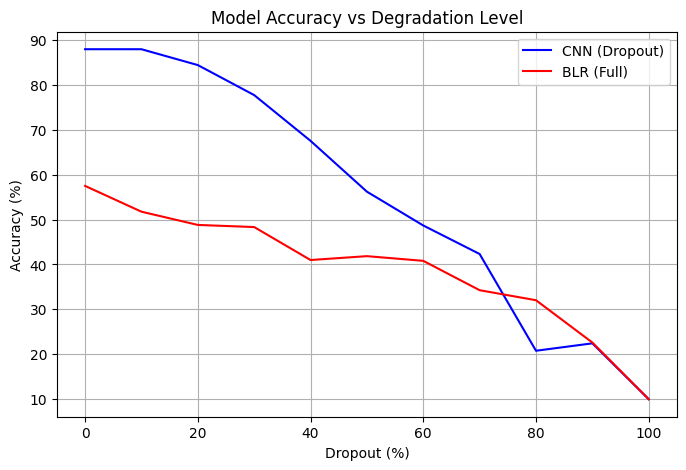

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(cnn_results_df["Degradation"], cnn_results_df["Accuracy (%)"], color = 'blue', label="CNN (Dropout)")
plt.plot(blr_results_df["Degradation"], blr_results_df["Accuracy (%)"], color = 'red', label="BLR (Full)")
#plt.plot(results_df["Degradation"], results_df["Acc (Weighted)"], color = 'green', label="Combined (Weighted Avg)")

plt.xlabel("Dropout (%)")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy vs Degradation Level")
plt.grid(True)
plt.legend()
plt.show()


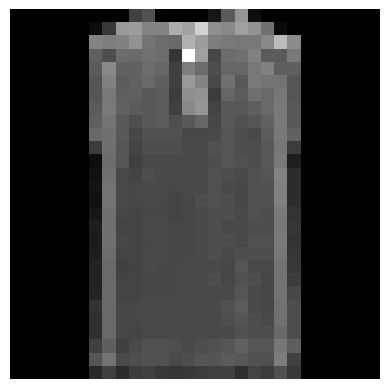

In [75]:
# one random image form the dataset
fashion_train_df = pd.read_csv('data_copy/raw/fashion-mnist-train.csv')
random_row = fashion_train_df.sample(1, random_state=2).iloc[0]
pixels = random_row.iloc[1:].to_numpy().reshape(28, 28)

plt.imshow(pixels, cmap='gray')
plt.axis('off')
plt.show()

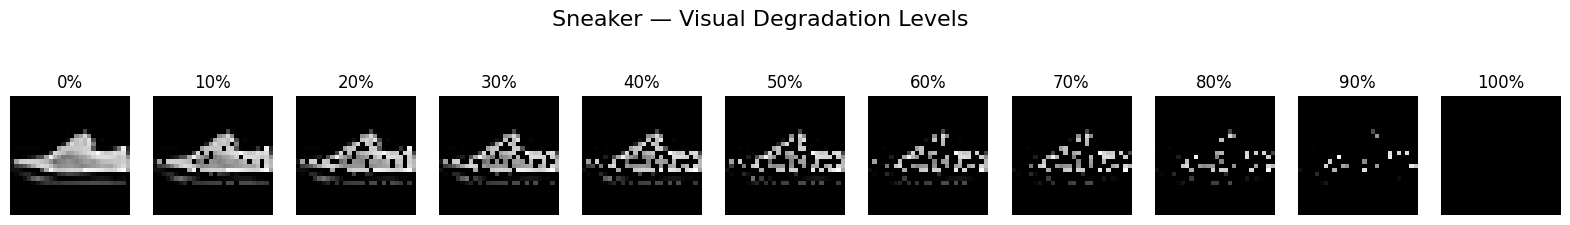

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

label_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# A function for one pixel dropout 
def degrade_image(image, dropout_ratio, hidden_value=0):
    img = image.copy().reshape(-1)
    n_pixels = img.size
    n_hide = int(n_pixels * dropout_ratio)

    np.random.seed(42)
    hide_idx = np.random.choice(n_pixels, n_hide, replace=False)
    img[hide_idx] = hidden_value

    return img.reshape(28, 28)


# Load image from dataframe exakctly as above
fashion_train_df = pd.read_csv('data_copy/raw/fashion-mnist-train.csv')
random_row = fashion_train_df.sample(1, random_state=42).iloc[0]

label = random_row.iloc[0]
label_name = label_map[int(label)] # mapping the label numbers to their names
image = random_row.iloc[1:].to_numpy().reshape(28, 28)

dropout_levels = [0,10,20,30,40,50,60,70,80,90,100]

# Single row plot
plt.figure(figsize=(20, 3))
for i, d in enumerate(dropout_levels):
    degraded = degrade_image(image, d/100)
    plt.subplot(1, len(dropout_levels), i+1)
    plt.imshow(degraded, cmap="gray")
    plt.title(f"{d}%")
    plt.axis("off")

plt.suptitle(f"{label_name} — Visual Degradation Levels", fontsize=16)
plt.show()

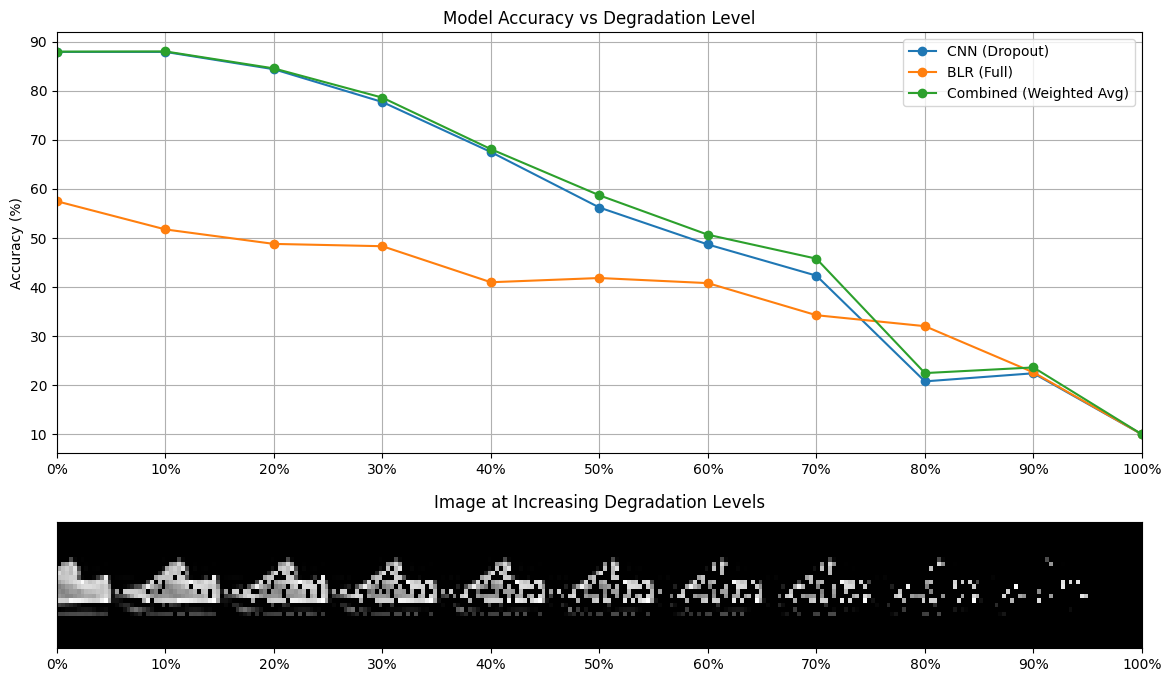

In [77]:
dropout_levels = cnn_results_df["Degradation"].to_list()  # ensures correct order
degraded_images = [degrade_image(image, d/100) for d in dropout_levels]


fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(
    2, 1,
    height_ratios=[4, 1.2],   # More space for the plot, less for images
    hspace=0.25               # THIS adds breathing room
)

# TOP PLOT
ax1 = fig.add_subplot(gs[0])
ax1.plot(cnn_results_df["Degradation"], cnn_results_df["Accuracy (%)"], 'o-', label="CNN (Dropout)")
ax1.plot(blr_results_df["Degradation"], blr_results_df["Accuracy (%)"], 'o-', label="BLR (Full)")
ax1.plot(results_df["Degradation"], results_df["Acc (Weighted)"], 'o-', label="Combined (Weighted Avg)")

ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Model Accuracy vs Degradation Level")
ax1.grid(True)
ax1.legend()
ax1.set_xlim(0, 100)     # Force full x-axis range

# IMAGE ROW ALIGNED TO SAME X-AXIS
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.set_yticks([])

# Set x-ticks and labels
ax2.set_xticks(dropout_levels)
ax2.set_xticklabels([f"{d}%" for d in dropout_levels], rotation=0)

# Place each image centered on each tick
img_width = 5   # controls spacing between the images

# AI was used here: 
for d, img in zip(dropout_levels, degraded_images):
    ax2.imshow(img, cmap="gray",
               extent=[d - img_width, d + img_width, 0, 1],
               aspect='auto')

ax2.set_title(f"Image at Increasing Degradation Levels", pad=10)
plt.show()

Trust the CNN predictions when degardation levels is below ~78% and BLR when is above. Basically from the graph we can see that we can trust more the cnn when quality of images is higher and use the linear model when noise dominates.


The threshold point is: 80


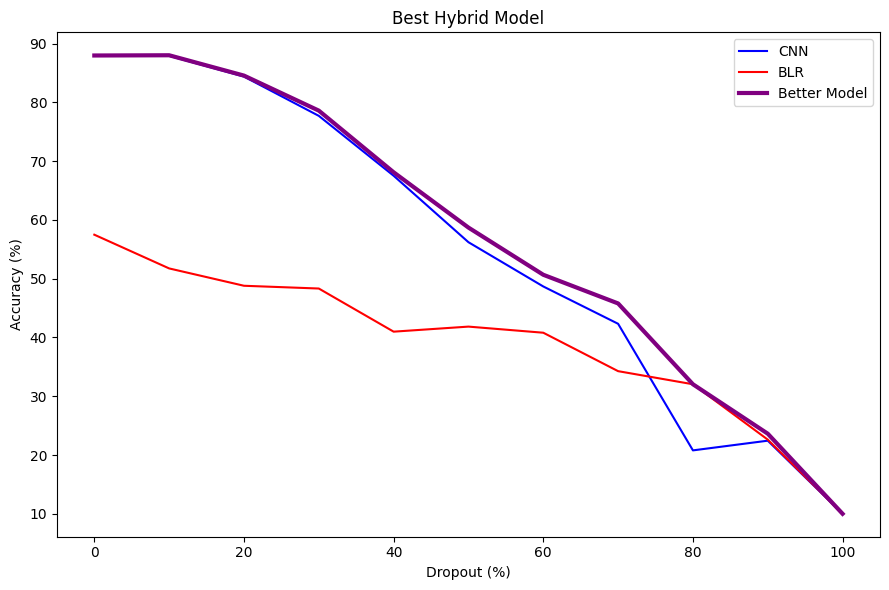

In [83]:
# Will try to create a hybrid that will take the max of weighted avg model and the part of BLR that exceeds it 
merged = (
    results_df.rename(columns={"Acc (Weighted)":"Accuracy_Weighted"})[["Degradation","Accuracy_Weighted"]]
    .merge(blr_results_df[["Degradation","Accuracy (%)"]].rename(columns={"Accuracy (%)":"Accuracy_BLR"}),
           on="Degradation", how="inner")
    .sort_values("Degradation"))

# Construct the hybrid by picking the highest accuracy
merged["Accuracy_Hybrid"] = merged[["Accuracy_Weighted","Accuracy_BLR"]].max(axis=1)

# Find the part the models performed 
switch_idx = (merged["Accuracy_BLR"] >= merged["Accuracy_Weighted"]).idxmax()  
switch_deg = merged.loc[switch_idx, "Degradation"] if (merged["Accuracy_BLR"] >= merged["Accuracy_Weighted"]).any() else None

print("The threshold point is:", switch_deg) 

plt.figure(figsize=(9,6))
plt.plot(cnn_results_df["Degradation"], cnn_results_df["Accuracy (%)"], color = 'blue', label="CNN")
plt.plot(blr_results_df["Degradation"], blr_results_df["Accuracy (%)"], color = 'red', label="BLR")
#plt.plot(results_df["Degradation"], results_df["Acc (Weighted)"], color = 'green', label="Combined (Weighted Avg)")
plt.plot(merged["Degradation"], merged["Accuracy_Hybrid"], linewidth=3, color="purple", label="Better Model")

plt.xlabel("Dropout (%)")
plt.ylabel("Accuracy (%)")
plt.title("Best Hybrid Model")
plt.legend()
plt.tight_layout()
plt.show()


2. Applying probability calibration to ensemble methods to predict 2-year mortality in patients with DLBCL
Shuanglong Fan, Zhiqiang Zhao, Hongmei Yu, Lei Wang, Chuchu Zheng, Xueqian Huang,
Zhenhuan Yang, Meng Xing, Qing Lu and Yanhong Luo

The third part is the combination of the base models. We used three methods (simple averaging, weighted averaging, and stacking) to combine the above 5 base models. Stacking or stacked generalization, which takes the outputs of the base models as its inputs, uses another machine learning algorithm (also called a meta-learner)

In [52]:
# Stacking meta-learner
def stacking_multinomial_from_frames(cnn_val_df, nb_val_df, cnn_test_df, nb_test_df):

    # Merge the two prediction files
    val_merged = cnn_val_df.merge(nb_val_df, on="id", suffixes=("_cnn", "_nb"))
    test_merged = cnn_test_df.merge(nb_test_df, on="id", suffixes=("_cnn", "_nb"))

    n_classes = 10  

    # Get the probability columns per class
    cnn_cols = [f"cnn_class_{i}" for i in range(n_classes)]
    nb_cols  = [f"nb_class_{i}"  for i in range(n_classes)]

    # Get the probability values per class
    cnn_val = val_merged[cnn_cols].values
    nb_val  = val_merged[nb_cols].values
    y_val   = val_merged["true_label_cnn"].values  

    cnn_test = test_merged[cnn_cols].values
    nb_test  = test_merged[nb_cols].values
    y_test   = test_merged["true_label_cnn"].values

    # Create the hstack table that will be needed for the regression 
    x_val  = np.hstack([cnn_val, nb_val])
    x_test = np.hstack([cnn_test, nb_test])

    # Train multinomial logistic regression
    stacker = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000)
    stacker.fit(x_val, y_val)

    # Get the predicted & calibrated probs 
    stacked_val  = stacker.predict_proba(x_val)
    stacked_test = stacker.predict_proba(x_test)

    return stacked_val, stacked_test, y_val, y_test, stacker, x_val, x_test

# Perform stacking 
stack_val, stack_test, y_val, y_test, stack_model, x_val, x_test = stacking_multinomial_from_frames(
    cnn_preds_val, nb_preds_val,
    cnn_preds_test, nb_preds_test)

/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [57]:
stack_val.shape

(24000, 10)

In [ ]:
degradation_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
records = []

for level in degradation_levels:
    # Load CNN + BLR predictions at this degradation level
    cnn_test_df = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    blr_test_df = pd.read_csv(f"blr_full_test_predictions_degradation_{level}.csv")

    # Standardize 
    cnn_test_df = standardise_df(cnn_test_df, "cnn")
    blr_test_df = standardise_df(blr_test_df, "blr")

    # Merge
    merged = cnn_test_df.merge(blr_test_df, on="id")
    y_true = merged["true_label_y"].values

    X_test = np.hstack([
        merged[[f"cnn_class_{i}" for i in range(10)]].values,
        merged[[f"blr_class_{i}" for i in range(10)]].values])

    # Use trained stack_model
    preds = stack_model.predict(X_test)
    acc = (preds == y_true).mean() * 100

    records.append({"Degradation": level, "Accuracy (%)": acc})

logreg_results_df = pd.DataFrame(records)


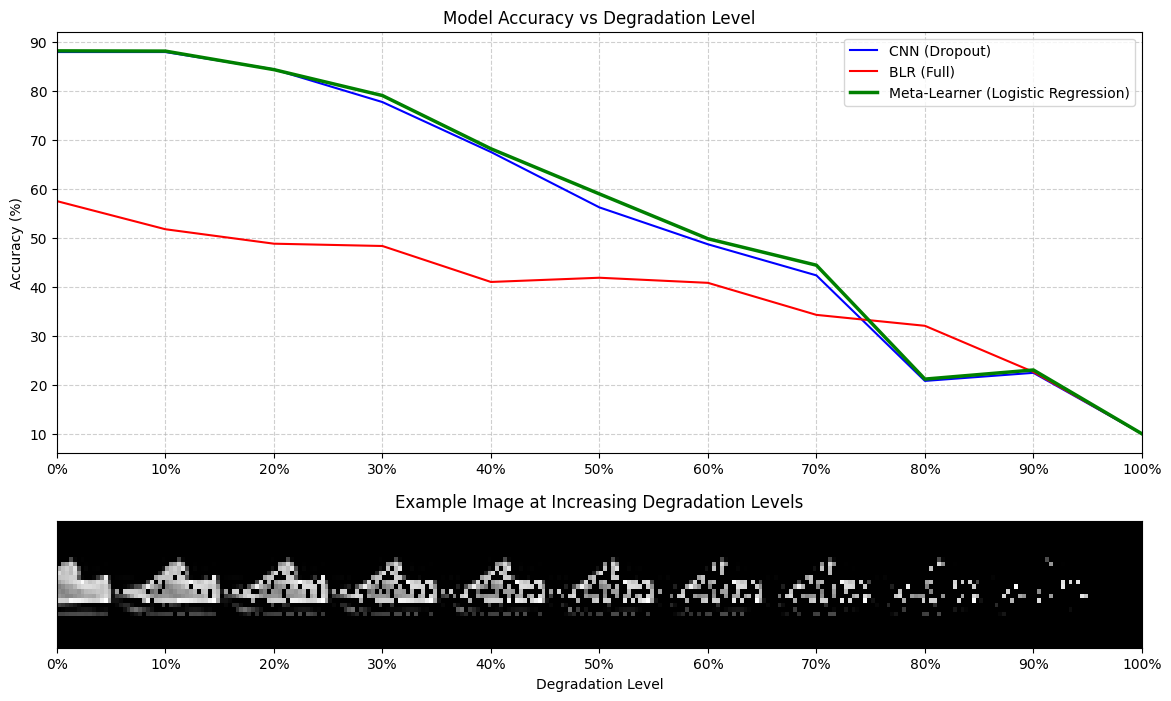

In [92]:
dropout_levels = logreg_results_df["Degradation"].to_list()
degraded_images = [degrade_image(image, d/100) for d in dropout_levels]

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1.2], hspace=0.25)

# graph
ax1 = fig.add_subplot(gs[0])
ax1.plot(cnn_results_df["Degradation"], cnn_results_df["Accuracy (%)"], color='blue', label="CNN (Dropout)")
ax1.plot(blr_results_df["Degradation"], blr_results_df["Accuracy (%)"], color='red', label="BLR (Full)")
ax1.plot(logreg_results_df["Degradation"], logreg_results_df["Accuracy (%)"], color = 'green', 
         label="Meta-Learner (Logistic Regression)", linewidth=2.5)

ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Model Accuracy vs Degradation Level")
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()
ax1.set_xlim(0, 100)

# images - degradation
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.set_yticks([])
ax2.set_xticks(dropout_levels)
ax2.set_xticklabels([f"{d}%" for d in dropout_levels])
ax2.set_xlabel("Degradation Level")

img_width = 5
for d, img in zip(dropout_levels, degraded_images):
    ax2.imshow(img, cmap="gray",
               extent=[d - img_width, d + img_width, 0, 1],
               aspect='auto')

ax2.set_title("Example Image at Increasing Degradation Levels", pad=10)
plt.show()


Switch threshold (where BLR overtakes Weighted Avg): 80


/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_1669/1952800149.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


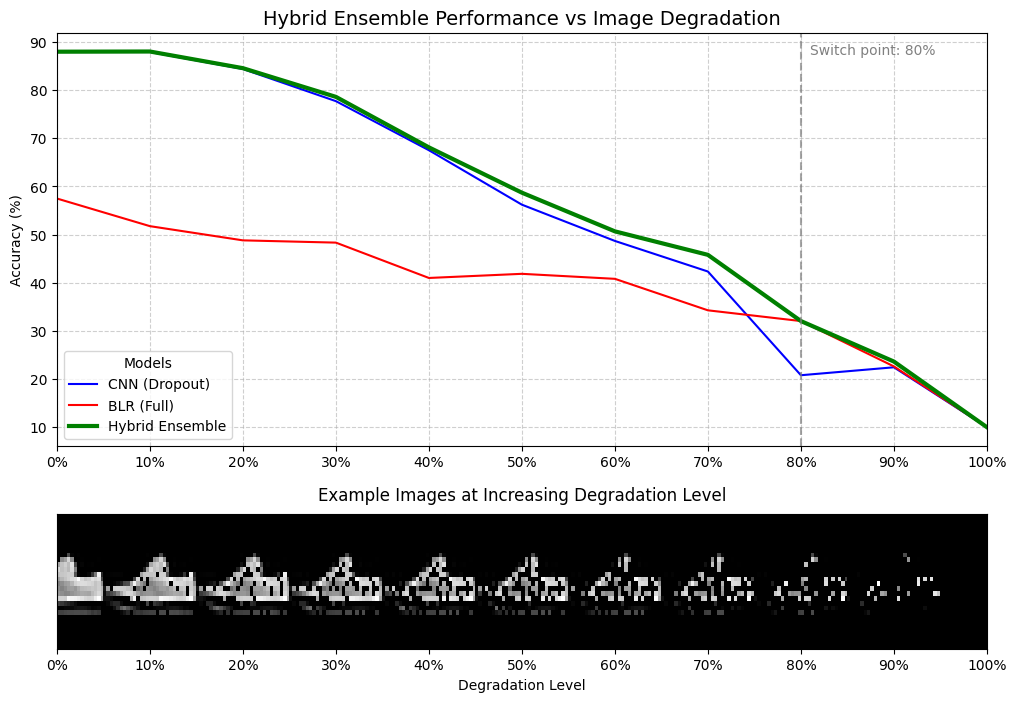

In [90]:
merged = (
    results_df.rename(columns={"Acc (Weighted)":"Accuracy_Weighted"})[["Degradation","Accuracy_Weighted"]]
    .merge(blr_results_df[["Degradation","Accuracy (%)"]].rename(columns={"Accuracy (%)":"Accuracy_BLR"}),
           on="Degradation", how="inner")
    .sort_values("Degradation")
)

# Pick the best performing model at each degradation level
merged["Accuracy_Hybrid"] = merged[["Accuracy_Weighted","Accuracy_BLR"]].max(axis=1)

# Find switch point
switch_idx = (merged["Accuracy_BLR"] >= merged["Accuracy_Weighted"]).idxmax()  
switch_deg = merged.loc[switch_idx, "Degradation"] if (merged["Accuracy_BLR"] >= merged["Accuracy_Weighted"]).any() else None
print("Switch threshold (where BLR overtakes Weighted Avg):", switch_deg)

dropout_levels = merged["Degradation"].to_list()
degraded_images = [degrade_image(image, d/100) for d in dropout_levels]

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[4, 1.3], hspace=0.25)

# model's graph
ax1 = fig.add_subplot(gs[0])
ax1.plot(cnn_results_df["Degradation"], cnn_results_df["Accuracy (%)"],
         color='blue', label="CNN (Dropout)")
ax1.plot(blr_results_df["Degradation"], blr_results_df["Accuracy (%)"],
         color='red', label="BLR (Full)")
ax1.plot(merged["Degradation"], merged["Accuracy_Hybrid"],
         linewidth=3, color="green", label="Hybrid Ensemble")

#ax1.set_xlabel("Degradation Level (%)")
ax1.set_ylabel("Accuracy (%)")
ax1.set_title("Hybrid Ensemble Performance vs Image Degradation", fontsize=14)
ax1.legend(title="Models", loc="best")
ax1.grid(True, linestyle="--", alpha=0.6)
ax1.set_xlim(0, 100)

if switch_deg is not None:
    ax1.axvline(switch_deg, color="gray", linestyle="--", alpha=0.7)
    ax1.text(switch_deg+1, ax1.get_ylim()[1]*0.95,
             f"Switch point: {switch_deg}%", color="gray", fontsize=10)

# images with degradation
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.set_yticks([])
ax2.set_xticks(dropout_levels)
ax2.set_xticklabels([f"{d}%" for d in dropout_levels])
ax2.set_xlabel("Degradation Level")

img_width = 5  
for d, img in zip(dropout_levels, degraded_images):
    ax2.imshow(img, cmap="gray",
               extent=[d - img_width, d + img_width, 0, 1],
               aspect='auto')

ax2.set_title("Example Images at Increasing Degradation Level", pad=10)

plt.tight_layout()
plt.show()

In [45]:
# Metrics for validation 
acc_stack_val = (np.argmax(stack_val, axis=1) == y_val).mean() * 100
nll_stack_val = log_loss(y_val, stack_val, labels=np.arange(stack_val.shape[1]))
ece_stack_val = ece_score(stack_val, y_val)

# Metrics for testing  
acc_stack_test = (np.argmax(stack_test, axis=1) == y_test).mean() * 100
nll_stack_test = log_loss(y_test, stack_test, labels=np.arange(stack_test.shape[1]))
ece_stack_test = ece_score(stack_test, y_test)

print(f"Accuracy Test (Stacking): {acc_stack_test}%")
print(f"Accuracy Val (Stacking): {acc_stack_val}%")
print()
print(f"NLL Val (Stacking): {nll_stack_val}")
print(f"NLL Test (Stacking): {nll_stack_test}")
print()
print(f"ECE Val (Stacking): {ece_stack_val}")
print(f"ECE Test (Stacking): {ece_stack_test}")
print()

Accuracy Test (Stacking): 89.125%
Accuracy Val (Stacking): 89.125%

NLL Val (Stacking): 0.33946814006061676
NLL Test (Stacking): 0.33151398862336223

ECE Val (Stacking): 0.01939700920065704
ECE Test (Stacking): 0.021683377131552058



In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(cnn_results_df["Degradation"], cnn_results_df["Accuracy (%)"], color = 'blue', label="CNN (Dropout)")
plt.plot(blr_results_df["Degradation"], blr_results_df["Accuracy (%)"], color = 'red', label="BLR (Full)")
plt.plot(results_df["Degradation"], results_df["Acc (Stacking)"], color = 'green', label="Combined (Stacking)")

plt.xlabel("Dropout (%)")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy vs Degradation Level")
plt.grid(True)
plt.legend()
plt.show()


Get coeffients of the meta learner (multinomial logistic regression)

In [58]:
# Rebuild meta-features outside the function 
n_classes = 10

# Merge CNN & BLR validation preds
val_merged = cnn_preds_val.merge(nb_preds_val, on="id", suffixes=("_cnn", "_nb"))
test_merged = cnn_preds_test.merge(nb_preds_test, on="id", suffixes=("_cnn", "_nb"))

# Extract probability matrices
cnn_val = val_merged[[f"cnn_class_{i}" for i in range(n_classes)]].values
nb_val  = val_merged[[f"nb_class_{i}"  for i in range(n_classes)]].values
cnn_test = test_merged[[f"cnn_class_{i}" for i in range(n_classes)]].values
nb_test  = test_merged[[f"nb_class_{i}"  for i in range(n_classes)]].values

# True labels
y_val  = val_merged["true_label_cnn"].values
y_test = test_merged["true_label_cnn"].values

# Combine 
x_val  = np.hstack([cnn_val, nb_val])
x_test = np.hstack([cnn_test, nb_test])


In [59]:
stack_model.fit(x_val, y_val)
feature_names = [f"cnn_class_{i}" for i in range(n_classes)] + [f"nb_class_{i}" for i in range(n_classes)]

coef_df = pd.DataFrame(stack_model.coef_, columns=feature_names)
coef_df.index = [f"class_{i}" for i in range(n_classes)]

print("\nMeta-learner Coefficients (per class)")
print(coef_df.round(4))


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Meta-learner Coefficients (per class)
         cnn_class_0  cnn_class_1  cnn_class_2  cnn_class_3  cnn_class_4  \
class_0       3.7243      -0.0030       0.7676      -1.3770      -0.5648   
class_1      -0.1718       4.5564      -1.3745       0.5861      -0.4229   
class_2      -0.2230      -1.4869       4.2586      -0.2788       1.0226   
class_3       0.4552       0.3027       0.5468       3.8284       1.2782   
class_4      -1.3220      -0.0374       0.8730      -1.0426       3.4019   
class_5      -1.3363      -0.8069      -1.6961      -0.7830      -1.3798   
class_6       1.8851      -0.7966       0.6674      -0.4538       0.3026   
class_7      -1.0650      -0.5489      -1.2258      -0.5793      -1.0667   
class_8      -0.8549      -0.8315      -1.4967       0.7976      -1.6469   
class_9      -1.0917      -0.3479      -1.3203      -0.6976      -0.9243   

         cnn_class_5  cnn_class_6  cnn_class_7  cnn_class_8  cnn_class_9  \
class_0      -0.4574       1.3781      -0.7203  

In [19]:
# Average coefficient magnitude per model (absolute - ignore the signs)
cnn_importance = coef_df[[c for c in coef_df.columns if "cnn" in c]].abs().mean().mean()
nb_importance  = coef_df[[c for c in coef_df.columns if "nb"  in c]].abs().mean().mean()

print(f"\nAverage |Coef| magnitude:")
print(f"  CNN features:  {cnn_importance:.4f}")
print(f"  NB features:   {nb_importance:.4f}")


Average |Coef| magnitude:
  CNN features:  1.1707
  NB features:   1.0206


In [20]:
# Average coefficient magnitude per model (absolute - ignore the signs)
cnn_per_class = coef_df[[f"cnn_class_{i}" for i in range(n_classes)]].abs().mean(axis=1)
nb_per_class  = coef_df[[f"nb_class_{i}"  for i in range(n_classes)]].abs().mean(axis=1)

# Compare them
pref_df = pd.DataFrame({
    "Class": coef_df.index,
    "CNN |Coef| Mean": cnn_per_class.round(3),
    "NB |Coef| Mean": nb_per_class.round(3),
    "Preferred Model": [
        "CNN" if cnn_per_class[i] > nb_per_class[i] else "NB"
        for i in range(len(coef_df))]})

print(pref_df.to_markdown(index=False))


| Class   |   CNN |Coef| Mean |   NB |Coef| Mean | Preferred Model   |
|:--------|------------------:|-----------------:|:------------------|
| class_0 |             1.202 |            1.188 | CNN               |
| class_1 |             1.086 |            0.955 | CNN               |
| class_2 |             1.004 |            0.836 | CNN               |
| class_3 |             1.046 |            0.937 | CNN               |
| class_4 |             1.261 |            1.053 | CNN               |
| class_5 |             1.43  |            1.184 | CNN               |
| class_6 |             1.123 |            0.788 | CNN               |
| class_7 |             1.301 |            1.215 | CNN               |
| class_8 |             0.994 |            0.96  | CNN               |
| class_9 |             1.26  |            1.089 | CNN               |


/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_1669/850195543.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  "CNN" if cnn_per_class[i] > nb_per_class[i] else "NB"


# SUMMARY FULL IMAGE

### Full Images – Combination Results

| Metric Direction | **↑ Accuracy** | **↓ NLL** | **↓ ECE** |
|:-------------------|:--------------:|:----------:|:----------:|
| **Individual Models (for reference)** | | | |
| Bayesian (BLR) | 57.49% | 0.8813 | 0.0223 |
| CNN (Calibrated)| 89.19% | 0.3113 | 0.0181 |
| **Combination Methods** | | | |
| Simple Average (50/50) | Val = 89.04%, Test = 89.35% | Val = 0.4819, Test = 0.4688 | Val = 0.1796, Test = 0.1835 |
| Weighted Average (AUC-based) | Val = 89.11%, Test = 89.44% | Val = 0.4111, Test = 0.3975 | Val = 0.1210, Test = 0.1251 |
| Stacking (Meta-Model) | Val = 89.51%, Test = 89.79% | Val = 0.3183, Test = 0.3045 | Val = 0.0099, Test = 0.0182 |

Observations:
- CNN performs strongly on its own (~89% accuracy), while the Bayesian model is much weaker (~55%).  
- All combination methods outperform individual models.  
- The Stacking meta-model achieves the best calibration (lowest ECE) and lowest NLL, with a good in accuracy.  
- This shows that the meta-learner effectively learns when to trust CNN vs Bayes.




### Meta-Learner Coefficient Summary — Full Images
| Metric | CNN Features | NB Features |
|:-------|:-------------:|:------------:|
| **Average \|Coef\| Magnitude** | **1.1503** | **0.9907** |

| Class | CNN \|Coef\ Mean | NB \|Coef\ Mean | Preferred Model |
|:------|------------------:|-----------------:|:----------------|
| class_0 | 1.186 | 1.230 | NB |
| class_1 | 1.145 | 0.950 | CNN |
| class_2 | 1.192 | 0.848 | CNN |
| class_3 | 0.865 | 0.886 | NB |
| class_4 | 1.098 | 1.086 | CNN |
| class_5 | 1.425 | 0.936 | CNN |
| class_6 | 1.112 | 0.897 | CNN |
| class_7 | 1.191 | 1.129 | CNN |
| class_8 | 0.976 | 0.900 | CNN |
| class_9 | 1.312 | 1.045 | CNN |

Mostly relies on the CNN, with consistently higher coefficients across most classes.
The Naive Bayes model contributes to two classes (class 0 and 3), but overall, the CNN dominates the combination strategy.

# SUMMARY DROPOUT IMAGES

### Dropout Images – Combination Results


| Metric Direction | **↑ Accuracy** | **↓ NLL** | **↓ ECE** |
|:-----------------|:--------------:|:----------:|:----------:|
| **Individual Models (for reference)** | | | |
| Bayesian (BLR) | 60.40% | 0.8476 | 0.0321 |
| CNN (Calibrated) | 87.92% | 0.3390 | 0.01 |
| **Combination Methods** | | | |
| Simple Average (50/50) | Val = 78.19%, Test = 77.38% | Val = 0.5984, Test = 0.6036 | Val = 0.0927, Test = 0.0875 |
| Weighted Average (AUC-based) | Val = 78.01%, Test = 77.13% | Val = 0.5842, Test = 0.5895 | Val = 0.0708, Test = 0.0745 |
| Stacking (Meta-Model) | Val = 82.80%, Test = 82.29% | Val = 0.4587, Test = 0.4721 | Val = 0.0125, Test = 0.0123 |

Observations: 
- With degraded images, both individual models lose accuracy as expected, however CNN remains stronger.
- The Stacking meta-model again provides the best balance. Even with degraded images is well colibrated (ECE ~0.012).

### Meta-Learner Coefficient Summary — Degraded Images

| Metric | CNN Features | NB Features |
|:-------|:-------------:|:------------:|
| **Average \|Coef\| Magnitude** | **1.1896** | **1.1933** |


| Class | CNN \|Coef\ Mean | NB \|Coef\ Mean | Preferred Model |
|:------|------------------:|-----------------:|:----------------|
| class_0 | 1.206 | 1.289 | NB |
| class_1 | 0.871 | 1.231 | NB |
| class_2 | 1.181 | 0.970 | CNN |
| class_3 | 1.325 | 1.084 | CNN |
| class_4 | 1.217 | 1.951 | NB |
| class_5 | 1.381 | 1.070 | CNN |
| class_6 | 1.230 | 1.182 | CNN |
| class_7 | 1.432 | 1.193 | CNN |
| class_8 | 0.986 | 0.973 | CNN |
| class_9 | 1.066 | 0.989 | CNN |

For degraded images, the meta-learner is more balanced, giving nearly equal overall weight to CNN and Naive Bayes features.
It trusts more the Bayes model for classes (0, 1, and 4).

# Train several meta learners 
Important to mention that i combined the predictions of CNN and BLR for both full and drop out images and all these 4 columns for 10 classes will be the 40 features that will be used to train a new meta learner. 

- A static one (Logistic Regression) that will learn the weights for each model and whether is a full or drop out images and apply it to make new predicions

- A dynamic one (Random Forest and Gradient Boosting) that will learn to adjust the weights based on the patterns observed in the input features

Since it combines the predictions from both full and degraded images it can be considered as a kind of data augmentation where the meta-model sees a wider range of inputs and learns to handle uncertainty

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import log_loss

In [63]:
# Load the csv files containing the predictions
def load_preds(path, prefix):
    df = pd.read_csv(path).copy()
    if "true_label" not in df.columns and "label" in df.columns:
        df = df.rename(columns={"label": "true_label"})
    prob_cols = [c for c in df.columns if "_class_" in c]
    for c in prob_cols:
        idx = c.split("_")[-1]
        df = df.rename(columns={c: f"{prefix}_class_{idx}"})
    if "id" not in df.columns:
        df.insert(0, "id", np.arange(len(df)))
    return df

cnn_full_train = load_preds("cnn_comb_train_calibrated_predictions.csv", "cnn_full")
cnn_full_test  = load_preds("cnn_comb_test_calibrated_predictions.csv", "cnn_full")

cnn_drop_train = load_preds("cnn_dropout_comb_train_calibrated_predictions.csv", "cnn_drop")
cnn_drop_test  = load_preds("cnn_dropout_comb_test_calibrated_predictions.csv", "cnn_drop")

blr_full_train = load_preds("blr_full_comb_train_predictions.csv", "blr_full")
blr_full_test  = load_preds("blr_full_comb_test_predictions.csv", "blr_full")

blr_drop_train = load_preds("blr_dropout_comb_train_predictions.csv", "blr_drop")
blr_drop_test  = load_preds("blr_dropout_comb_test_predictions.csv", "blr_drop")

In [64]:
# drop duplicate true label columns before merging otherwise python complaints  
def drop_extra_labels(df):
    cols = [c for c in df.columns if "true_label" in c]
    if len(cols) > 1:
        df = df.drop(columns=cols[1:])
    return df

cnn_full_train = drop_extra_labels(cnn_full_train)
cnn_drop_train = drop_extra_labels(cnn_drop_train)
blr_full_train = drop_extra_labels(blr_full_train)
blr_drop_train = drop_extra_labels(blr_drop_train)

cnn_full_test = drop_extra_labels(cnn_full_test)
cnn_drop_test = drop_extra_labels(cnn_drop_test)
blr_full_test = drop_extra_labels(blr_full_test)
blr_drop_test = drop_extra_labels(blr_drop_test)

# Merge datasets on id
train_df = (
    cnn_full_train
    .merge(cnn_drop_train, on="id", suffixes=("", "_dup1"))
    .merge(blr_full_train, on="id", suffixes=("", "_dup2"))
    .merge(blr_drop_train, on="id", suffixes=("", "_dup3")))

test_df = (
    cnn_full_test
    .merge(cnn_drop_test, on="id", suffixes=("", "_dup1"))
    .merge(blr_full_test, on="id", suffixes=("", "_dup2"))
    .merge(blr_drop_test, on="id", suffixes=("", "_dup3")))

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (19200, 45) Test: (4800, 45)


In [65]:
# Split dependent and independent vars 
feature_cols = [c for c in train_df.columns if "_class_" in c]
X_train = train_df[feature_cols].values
y_train = train_df["true_label"].values 
X_test  = test_df[feature_cols].values
y_test  = test_df["true_label"].values

print("Features:", len(feature_cols))

# Meta-learners used 
models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class="multinomial", C=0.1, penalty="l2"  ),
    "RF": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0),
    "GBM": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)}

# Fit, test each of them and evaluate them 
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    probs_val = model.predict_proba(X_train)
    probs_test = model.predict_proba(X_test)

    acc_val = (np.argmax(probs_val, 1) == y_train).mean() * 100
    acc_test = (np.argmax(probs_test, 1) == y_test).mean() * 100
    nll_val = log_loss(y_train, probs_val, labels=np.arange(probs_val.shape[1]))
    nll_test = log_loss(y_test, probs_test, labels=np.arange(probs_test.shape[1]))
    ece_val = ece_score(probs_val, y_train)
    ece_test = ece_score(probs_test, y_test)

    results.append({
        "Model": name,
        "Accuracy (Val)": acc_val,
        "Accuracy (Test)": acc_test,
        "NLL (Val)": nll_val,
        "NLL (Test)": nll_test,
        "ECE (Val)": ece_val,
        "ECE (Test)": ece_test})


Features: 40


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [61]:
# Summary 
results_df = pd.DataFrame(results)
display(results_df.style.format({
    "Accuracy (Val)": "{:.2f}%",
    "Accuracy (Test)": "{:.2f}%",
    "NLL (Val)": "{:.4f}",
    "NLL (Test)": "{:.4f}",
    "ECE (Val)": "{:.4f}",
    "ECE (Test)": "{:.4f}"}))


,Model,Accuracy (Val),Accuracy (Test),NLL (Val),NLL (Test),ECE (Val),ECE (Test)
0,LogReg,89.43%,89.96%,0.3122,0.2965,0.0119,0.0174
1,RF,100.00%,90.11%,0.0676,0.3156,0.0598,0.0322
2,GBM,94.25%,89.60%,0.1654,0.2921,0.0297,0.0189


 Check the coefficients or importance given to each model (CNN or BLR) and image type (full or degraded)

In [62]:
# Extract absolute coefficients
coef = np.abs(stack_model.coef_)  
avg_importance = coef.mean(axis=0)

# number of features
n_features = avg_importance.shape[0]
feature_names_used = feature_cols[:n_features] 

importance_df = pd.DataFrame({
    'feature': feature_names_used,
    'importance': avg_importance})

# Group features by model and image source
importance_df['source'] = importance_df['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other'))

# Aggregate importance
grouped = importance_df.groupby('source')['importance'].mean().sort_values(ascending=False)
print("Logistic Regression Feature Importance")
print(grouped)


Logistic Regression Feature Importance
source
CNN (Full)    1.230778
CNN (Drop)    1.119967
Name: importance, dtype: float64


In [27]:
# Fit each meta-learner outside the function
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0)
rf_model.fit(X_train, y_train)

gbm_model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)
gbm_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [28]:
import shap

# SHAP explainer for RF
explainer_rf = shap.TreeExplainer(rf_model)
# (n_samples, n_features)
shap_values_rf = explainer_rf.shap_values(X_test)  

# Stack across classes (n_classes, n_samples, n_features)
shap_values_rf_stacked = np.stack(shap_values_rf, axis=0)

# Take mean absolute value across classes and samples (n_features,)
mean_abs_shap_rf = np.abs(shap_values_rf_stacked).mean(axis=(0, 1))  

# Check length match
if len(mean_abs_shap_rf) != len(feature_cols):
    print(f"Warning: feature mismatch ({len(mean_abs_shap_rf)} shap vs {len(feature_cols)} features)")
    feature_cols = feature_cols[:len(mean_abs_shap_rf)]

# Build dataframe
importance_df_rf = pd.DataFrame({
    'feature': feature_cols,
    'importance': mean_abs_shap_rf})

# Group by model/image type
importance_df_rf['source'] = importance_df_rf['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other'))

# Aggregate results
grouped_rf = importance_df_rf.groupby('source')['importance'].mean().sort_values(ascending=False)
print("Random Forest SHAP Feature Importance")
print(grouped_rf)


Random Forest SHAP Feature Importance
source
CNN (Full)    0.006416
Name: importance, dtype: float64


on average, the CNN (Full) features lead to a 0.6% change in the meta-learner’s predicted probabilities for each sample
Since all other feature groups contribute almost nothing, this means that RF almost relies fully on CNN (Full) for making decisions

In [29]:
# for debugging the mistake with the sizes 
print("X_train shape:", X_train.shape)
print("Model trained on features:", rf_model.n_features_in_)
print("SHAP output shape:", np.array(shap_values_rf).shape)


X_train shape: (24000, 40)
Model trained on features: 40
SHAP output shape: (10000, 40, 10)


In [30]:
# RF
predict_fn = gbm_model.predict_proba

# SHAP 
explainer_gbm = shap.Explainer(predict_fn, X_test, algorithm='permutation')
shap_values_gbm = explainer_gbm(X_test)

# Multi-class SHAP (n_samples, n_features, n_classes)
shap_vals = shap_values_gbm.values
if shap_vals.ndim == 3:
    mean_abs_shap_gbm = np.abs(shap_vals).mean(axis=(0, 2))
else:
    mean_abs_shap_gbm = np.abs(shap_vals).mean(axis=0)

# Align feature lengths 
n_features = min(len(feature_cols), len(mean_abs_shap_gbm))
feature_names = feature_cols[:n_features]
mean_abs_shap_gbm = mean_abs_shap_gbm[:n_features]

importance_df_gbm = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap_gbm})

# Assign labels
importance_df_gbm['source'] = importance_df_gbm['feature'].apply(
    lambda f: (
        'CNN (Full)' if 'cnn_full' in f else
        'CNN (Drop)' if 'cnn_drop' in f else
        'BLR (Full)' if 'blr_full' in f else
        'BLR (Drop)' if 'blr_drop' in f else 'Other'))

# Aggregate
grouped_gbm = importance_df_gbm.groupby('source')['importance'].mean().sort_values(ascending=False)
print("Gradient Boosting SHAP Feature Importance")
print(grouped_gbm)


PermutationExplainer explainer: 10001it [1:37:34,  1.71it/s]                           

Gradient Boosting SHAP Feature Importance
source
CNN (Full)    0.016759
Name: importance, dtype: float64


On average CNN (Full) lead to 1.5% change in the GB model's predicted probs for each sample. The importance for the rest features is almost zero which means that the model relies almost fully on CNN (Full) when making its decisions

### Meta-Learner (Full & Dropout Images Predictions)

### Overall Performance Comparison — Full vs Degraded Images

| Metric Direction | **↑ Accuracy** | **↓ NLL** | **↓ ECE** |
|:-------------------|:--------------:|:----------:|:----------:|
| Bayesian (BLR, Full Images) | Test = 54.63% | Test = 0.8906 | Test = 0.0197 |
| Bayesian (BLR, Degraded Images) | Test = 57.37% | Test = 0.8715 | Test = 0.0290 |
| CNN (Calibrated, Full Images) | Test = 89.19% | Test = 0.3113 | Test = 0.0181 |
| CNN (Calibrated, Degraded Images) | Test = 89.19% | Test = 0.3113 | Test = 0.0181 |
| Logistic Regression (Meta-Learner) | Val = 89.71%, Test = 89.81% | Val = 0.3007, Test = 0.2988 | Val = 0.0065, Test = 0.0097 |
| Logistic Regression with Regularis. (Meta-Learner) | Val = 89.57%, Test = 89.92% | Val = 0.3147, Test = 0.3085 | Val = 0.0132, Test = 0.0216 |
| Random Forest (Meta-Learner) | Val = 100.00%, Test = 90.29% | Val = 0.0687, Test = 0.3228 | Val = 0.0608, Test = 0.0264 |
| Gradient Boosting (Meta-Learner) | Val = 95.19%, Test = 89.60% | Val = 0.1474, Test = 0.2999 | Val = 0.0325, Test = 0.0235 |

- Logistic Regression provides the best generalization (lowest NLL & ECE on both val/test)
- Random Forest clearly overfits (100% Val Acc but drop on Test + higher NLL)
- Gradient Boosting performs well, slightly under LogReg, showing slight overfitting too 

Logistic Regression is the best for now (static) for the other nonlinear cases i should optimise them to improve generalisation

After performing the SHAP analysis on the RF nad GB meta learnes we found that both models relied almost fully on the CNN (Full) for making predictions. Extremely small contributions from the BLR and degraded images. Logistic Regression relied on CNN (Full) and CNN(Degraded) however, again the the full images were more significant for the prediction.  





In [66]:
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    probs_val = model.predict_proba(X_train)
    probs_test = model.predict_proba(X_test)

    acc_val = (np.argmax(probs_val, 1) == y_train).mean() * 100
    acc_test = (np.argmax(probs_test, 1) == y_test).mean() * 100
    nll_val = log_loss(y_train, probs_val, labels=np.arange(probs_val.shape[1]))
    nll_test = log_loss(y_test, probs_test, labels=np.arange(probs_test.shape[1]))
    ece_val = ece_score(probs_val, y_train)
    ece_test = ece_score(probs_test, y_test)

    # AIC computation
    N_train = len(y_train)
    N_test = len(y_test)
    if isinstance(model, LogisticRegression):
        k = model.coef_.size + model.intercept_.size
    else:
        # rough approximation for ensemble models
        k = X_train.shape[1]  # feature count as a proxy

    aic_val = 2 * k + 2 * N_train * nll_val
    aic_test = 2 * k + 2 * N_test * nll_test

    results.append({
        "Model": name,
        "Accuracy (Val)": acc_val,
        "Accuracy (Test)": acc_test,
        "NLL (Val)": nll_val,
        "NLL (Test)": nll_test,
        "ECE (Val)": ece_val,
        "ECE (Test)": ece_test,
        "AIC (Val)": aic_val,
        "AIC (Test)": aic_test
    })

results_df = pd.DataFrame(results)
display(results_df.style.format({
    "Accuracy (Val)": "{:.2f}%",
    "Accuracy (Test)": "{:.2f}%",
    "NLL (Val)": "{:.4f}",
    "NLL (Test)": "{:.4f}",
    "ECE (Val)": "{:.4f}",
    "ECE (Test)": "{:.4f}",
    "AIC (Val)": "{:.2f}",
    "AIC (Test)": "{:.2f}"
}))


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Model,Accuracy (Val),Accuracy (Test),NLL (Val),NLL (Test),ECE (Val),ECE (Test),AIC (Val),AIC (Test)
0,LogReg,89.14%,89.08%,0.3616,0.3539,0.0326,0.0288,14703.92,4217.32
1,RF,100.00%,89.12%,0.0775,0.3658,0.0687,0.0466,3055.22,3592.12
2,GBM,93.78%,88.56%,0.1773,0.3430,0.0310,0.0196,6889.45,3372.87


# Compare degradation level with models' accuracy 

In [31]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

def load_level(level):
    cnn = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    blr = pd.read_csv(f"blr_full_test_predictions_degradation_{level}.csv")
    cnn = standardise_df(cnn, want_prefix="cnn_drop")
    blr = standardise_df(blr, want_prefix="blr_full")
    merged   = cnn.merge(blr, on="id")
    y   = merged["true_label_y"].values
    X   = np.hstack([
        merged[[f"cnn_drop_class_{i}" for i in range(10)]].values,
        merged[[f"blr_full_class_{i}" for i in range(10)]].values])
    
    X[:, :10]/= X[:, :10].sum(axis=1, keepdims=True)
    X[:, 10:]/= X[:, 10:].sum(axis=1, keepdims=True)
    return X, y

def eval_per_level(level):
    X, y = load_level(level)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    accs, nlls = [], []
    eces = []
    for tr, te in skf.split(X, y):
        model = LogisticRegression(max_iter=1000, multi_class="multinomial", C=0.5)
        model.fit(X[tr], y[tr])
        P = model.predict_proba(X[te])
        accs.append((P.argmax(1) == y[te]).mean()*100)
        nlls.append(log_loss(y[te], P, labels=np.arange(P.shape[1])))
        eces.append(ece_score(P, y[te]))
    return {
        "Degradation": level,
        "Model": "LogReg",
        "Acc": np.mean(accs),
        "NLL": np.mean(nlls),
        "ECE": np.mean(eces)}

levels = [0,10,20,30,40,50,60,70,80,90,100]
per_level_meta = pd.DataFrame([eval_per_level(L) for L in levels])
print(per_level_meta)


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py

    Degradation   Model    Acc       NLL           ECE
0             0  LogReg  88.48  0.342243  2.251348e-02
1            10  LogReg  88.59  0.342859  2.415991e-02
2            20  LogReg  87.14  0.376211  2.341701e-02
3            30  LogReg  83.16  0.466111  2.807448e-02
4            40  LogReg  77.56  0.579892  3.796414e-02
5            50  LogReg  75.76  0.646862  4.513804e-02
6            60  LogReg  74.41  0.717440  4.739119e-02
7            70  LogReg  70.80  0.824505  6.412544e-02
8            80  LogReg  60.91  1.049959  9.515428e-02
9            90  LogReg  49.51  1.318864  1.051860e-01
10          100  LogReg  10.00  2.302585  1.387779e-17


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def eval_per_level(level, model_name, model):
    X, y = load_level(level)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    acc, nll, ece = [], [], []
    for tr, te in skf.split(X, y):
        model.fit(X[tr], y[tr])
        P = model.predict_proba(X[te])
        acc.append((P.argmax(1) == y[te]).mean()*100)
        nll.append(log_loss(y[te], P, labels=np.arange(P.shape[1])))
        ece.append(ece_score(P, y[te]))
    return {
        "Degradation": level,
        "Model": model_name,
        "Acc": np.mean(acc),
        "NLL": np.mean(nll),
        "ECE": np.mean(ece)}


In [90]:
levels = [0,10,20,30,40,50,60,70,80,90,100]
meta_results_all = []

for level in levels:

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000, C=0.5) 
    meta_results_all.append(eval_per_level(level, "LogReg", logreg))

    # Random Forest
    rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0)
    meta_results_all.append(eval_per_level(level, "RF", rf))

    # Gradient Boosting
    gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)
    meta_results_all.append(eval_per_level(level, "GBM", gb))

meta_results_df = pd.DataFrame(meta_results_all)
meta_results_df.to_csv("meta_learners_per_level_results.csv", index=False)
print(meta_results_df)


    Degradation   Model    Acc       NLL           ECE
0             0  LogReg  88.48  0.342243  2.251348e-02
1             0      RF  88.49  0.389017  2.122650e-02
2             0     GBM  88.06  0.359694  3.522476e-02
3            10  LogReg  88.59  0.342859  2.415991e-02
4            10      RF  88.64  0.383141  2.258300e-02
5            10     GBM  87.80  0.365126  3.656503e-02
6            20  LogReg  87.14  0.376211  2.341701e-02
7            20      RF  87.33  0.407423  2.448800e-02
8            20     GBM  86.99  0.383313  3.770631e-02
9            30  LogReg  83.16  0.466111  2.807448e-02
10           30      RF  85.16  0.443278  3.555250e-02
11           30     GBM  84.59  0.428142  3.487996e-02
12           40  LogReg  77.56  0.579892  3.796414e-02
13           40      RF  83.27  0.500323  4.932000e-02
14           40     GBM  82.72  0.480055  3.564253e-02
15           50  LogReg  75.76  0.646862  4.513804e-02
16           50      RF  81.97  0.508877  5.983750e-02
17        

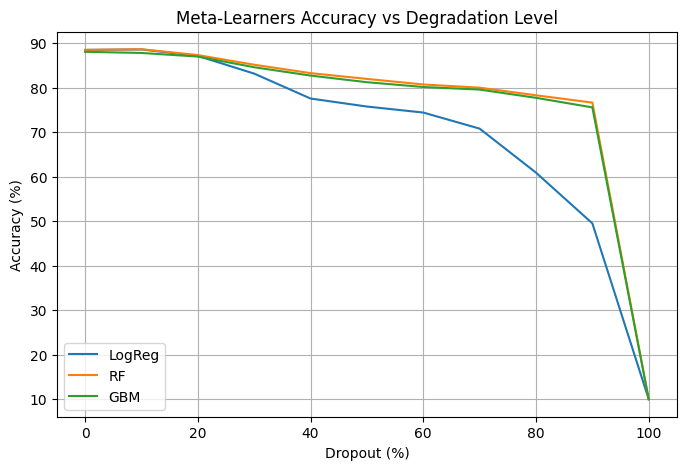

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for m in ["LogReg", "RF", "GBM"]:
    subset = meta_results_df[meta_results_df["Model"] == m]
    plt.plot(subset["Degradation"], subset["Acc"], label=m)

plt.xlabel("Dropout (%)")
plt.ylabel("Accuracy (%)")
plt.title("Meta-Learners Accuracy vs Degradation Level")
plt.legend()
plt.grid(True)
plt.show()


In [92]:
importance_results = []

for level in [0,10,20,30,40,50,60,70,80,90,100]:
    X, y = load_level(level)

    models = {
        "LogReg": LogisticRegression(max_iter=1000, C=0.5),
        "RF": RandomForestClassifier(n_estimators=200, random_state=0),
        "GBM": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0)}

    for name, model in models.items():
        model.fit(X, y)
        
        # Get feature importances depending on model type
        if hasattr(model, "coef_"):  
            #absolute value of the model’s coefficients averaged across all classes
            importances = np.abs(model.coef_).mean(axis=0)
        else:  
            importances = model.feature_importances_

        # Average CNN vs BLR importance
        # feature importance scores computed from the trained trees 
        # how much each feature reduces gini impurity 
        cnn_importance = importances[:10].mean()
        blr_importance = importances[10:].mean()

        # normalise
        total = cnn_importance + blr_importance
        cnn_ratio = cnn_importance / total
        blr_ratio = blr_importance / total

        importance_results.append({
            "Degradation": level,
            "Model": name,
            "CNN Importance": cnn_ratio,
            "BLR Importance": blr_ratio})

importance_df = pd.DataFrame(importance_results)
importance_df.to_csv("meta_feature_importance_per_level.csv", index=False)
print(importance_df.head())


/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_6896/1511258051.py:29: RuntimeWarning: invalid value encountered in scalar divide
  cnn_ratio = cnn_importance / total
/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_6896/1511258051.py:30: RuntimeWarning: invalid value encountered in scalar divide
  blr_ratio = blr_importance / total
/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_6896/1511258051.py:29: RuntimeWarning: invalid value encountered in scalar divide
  cnn_ratio = cnn_importance / total
/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_6896/1511258051.py:30: RuntimeWarning: invalid value encountered in scalar divide
  blr_ratio = blr_importance / total


   Degradation   Model  CNN Importance  BLR Importance
0            0  LogReg        0.570254        0.429746
1            0      RF        0.721601        0.278399
2            0     GBM        0.963121        0.036879
3           10  LogReg        0.579673        0.420327
4           10      RF        0.728161        0.271839


/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_6896/1511258051.py:29: RuntimeWarning: invalid value encountered in scalar divide
  cnn_ratio = cnn_importance / total
/var/folders/bq/qnrb3lm539nfznyv5cmr8rph0000gn/T/ipykernel_6896/1511258051.py:30: RuntimeWarning: invalid value encountered in scalar divide
  blr_ratio = blr_importance / total


Based on ideas from the following papers: 
1. Advances and Challenges in Meta-Learning: A Technical Review https://ieeexplore.ieee.org/abstract/document/10413635 
2. Meta-Learning: A Survey https://arxiv.org/pdf/1810.03548
3. A SIMPLE NEURAL ATTENTIVE META-LEARNER https://arxiv.org/pdf/1707.03141

I decided to experiment a bit with black-box meta-learners techniques such as MANN, SNAIL, LSTM. Some of them like MANN and LSTM are not probably suitable for this task as the data volume we have probably won't be enough and for the purpose they were built in the first place. To be more specific, Long Short-Term Memory technique is better for sequential data like time-series eg, speed recognition. Memory-Augmented Neural Networks are good for complex tasks that involve long-term data dependencies and storage eg, question answering and machine translation. Lastly Simple Neural AttentIve Learner (or SNAIL) that combines temporal convolutions, which enable the meta-learner to aggregate contextual information from past experience, with causal attention. That was the inspiration behind our idea to apply something similar to this project. We used instead a simple  attention-based multi-layer perceptron (MLP) as our meta-learner. We trained the MLP to learn how to combine CNN and BLR probabilistic outputs using different degradation levels. We use each degradation level as a seperate task to capture the patterns on how the reliability of each separate moedel changes with the degradation level. This can be similar to the causal attention ideas in the paper, as the MLP learns to be context-aware (degradation) and dynamically reweighting the models' outputs based on the conditional degradation. 

Here we are building a small feedforward NN. It uses 20 class probabilities (10 from cnn and 10 from BLR) and one degradation indicator (total 21 features). We have 11 degradation levels, starting from 0 to 100 with intervals of 10 that is used as a factor for deciding which model to trust the most in each level of degradation. 


In [96]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold

def load_level(level):
    # Reuse your files
    cnn = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    blr = pd.read_csv(f"blr_full_test_predictions_degradation_{level}.csv")

    # Standardise using the function 
    cnn = standardise_df(cnn.copy(), want_prefix="cnn_drop")
    blr = standardise_df(blr.copy(), want_prefix="blr_full")

    # Merge the files based on the id column 
    merged = cnn.merge(blr, on="id")
    # Get the dependent and independend variables 
    y = merged["true_label_y"].values
    X = np.hstack([
        merged[[f"cnn_drop_class_{i}" for i in range(10)]].values,
        merged[[f"blr_full_class_{i}" for i in range(10)]].values])
    
    # Normalise to ensure valid probabilities 
    X[:, :10]  /= X[:, :10].sum(axis=1, keepdims=True)
    X[:, 10:]  /= X[:, 10:].sum(axis=1, keepdims=True)
    return X, y

# Degradation levels we used for making predictions 
levels = [0,10,20,30,40,50,60,70,80,90,100]
mlp_results = []

for lev in levels:
    X, y = load_level(lev)
    # Use stratified k-fold to ensure we can the class distribution of the origininal dataset 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Save accuracy, NLL, ECE
    acc = []
    nll = []
    ece = []

    # Foe each k fold combination train an MPL 
    for tr, te in skf.split(X, y):
        mlp = MLPClassifier(
            hidden_layer_sizes=(64, 32),
            #activation="relu", 
            activation = "tanh",
            solver="adam",
            # Use L2 weight decay 
            alpha=1e-4,     
            learning_rate_init=1e-3,
            max_iter=200,
            random_state=0)
        # Fit the model 
        mlp.fit(X[tr], y[tr])
        # Get the probabilities 
        probs = mlp.predict_proba(X[te])
        # Measure the metrics we are interested in 
        acc.append((probs.argmax(1) == y[te]).mean()*100)
        nll.append(log_loss(y[te], probs, labels=np.arange(probs.shape[1])))
        ece.append(ece_score(probs, y[te]))

    mlp_results.append({
        "Degradation": lev,
        "Model": "MLP",
        "Acc": np.mean(acc),
        "NLL": np.mean(nll),
        "ECE": np.mean(ece)})

mlp_results_df = pd.DataFrame(mlp_results)
print(mlp_results_df)


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/ioann

    Degradation Model    Acc       NLL       ECE
0             0   MLP  88.41  0.336697  0.014533
1            10   MLP  88.55  0.335322  0.017944
2            20   MLP  87.18  0.363249  0.020103
3            30   MLP  84.18  0.430739  0.019394
4            40   MLP  80.63  0.512568  0.024682
5            50   MLP  77.60  0.588183  0.026189
6            60   MLP  76.22  0.644233  0.029294
7            70   MLP  74.16  0.695444  0.031803
8            80   MLP  67.91  0.849582  0.032007
9            90   MLP  57.95  1.057567  0.028756
10          100   MLP  10.00  2.303430  0.006500


In [97]:
from sklearn.metrics import accuracy_score, log_loss
degradation_levels = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cnn_results, blr_results = [], []

for level in degradation_levels:
    # CNN
    cnn_df = pd.read_csv(f"cnn_dropout_test_predictions_degradation_{level}.csv")
    y_true = cnn_df["true_label"].to_numpy()
    cnn_probs = cnn_df[[c for c in cnn_df.columns if "cnn_dropout_class_" in c]].to_numpy()
    cnn_probs /= cnn_probs.sum(axis=1, keepdims=True)  # normalize
    cnn_acc = accuracy_score(y_true, cnn_probs.argmax(axis=1)) * 100
    cnn_nll = log_loss(y_true, cnn_probs, labels=np.arange(10))
    cnn_ece = ece_score(cnn_probs, y_true)
    cnn_results.append({"Degradation": level, "Accuracy (%)": cnn_acc, "NLL": cnn_nll, "ECE": cnn_ece})

    # BLR
    blr_df = pd.read_csv(f"blr_full_test_predictions_degradation_{level}.csv")
    y_true = blr_df["true_label"].to_numpy() if "true_label" in blr_df else blr_df["label"].to_numpy()
    blr_probs = blr_df[[c for c in blr_df.columns if "blr_full_class_" in c]].to_numpy()
    blr_probs /= blr_probs.sum(axis=1, keepdims=True)
    blr_acc = accuracy_score(y_true, blr_probs.argmax(axis=1)) * 100
    blr_nll = log_loss(y_true, blr_probs, labels=np.arange(10))
    blr_ece = ece_score(blr_probs, y_true)
    blr_results.append({"Degradation": level, "Accuracy (%)": blr_acc, "NLL": blr_nll, "ECE": blr_ece})

cnn_results_df = pd.DataFrame(cnn_results)
blr_results_df = pd.DataFrame(blr_results)


In [98]:
cnn_results_df["Model"] = "CNN"
blr_results_df["Model"] = "BLR"
mlp_results_df["Model"] = "MLP"
all_results_df = pd.concat([cnn_results_df, blr_results_df, mlp_results_df], ignore_index=True)


In [99]:
mlp_results_df

,Degradation,Model,Acc,NLL,ECE
0,0,MLP,88.41,0.336697,0.014533
1,10,MLP,88.55,0.335322,0.017944
2,20,MLP,87.18,0.363249,0.020103
3,30,MLP,84.18,0.430739,0.019394
4,40,MLP,80.63,0.512568,0.024682
5,50,MLP,77.60,0.588183,0.026189
6,60,MLP,76.22,0.644233,0.029294
7,70,MLP,74.16,0.695444,0.031803
8,80,MLP,67.91,0.849582,0.032007
9,90,MLP,57.95,1.057567,0.028756


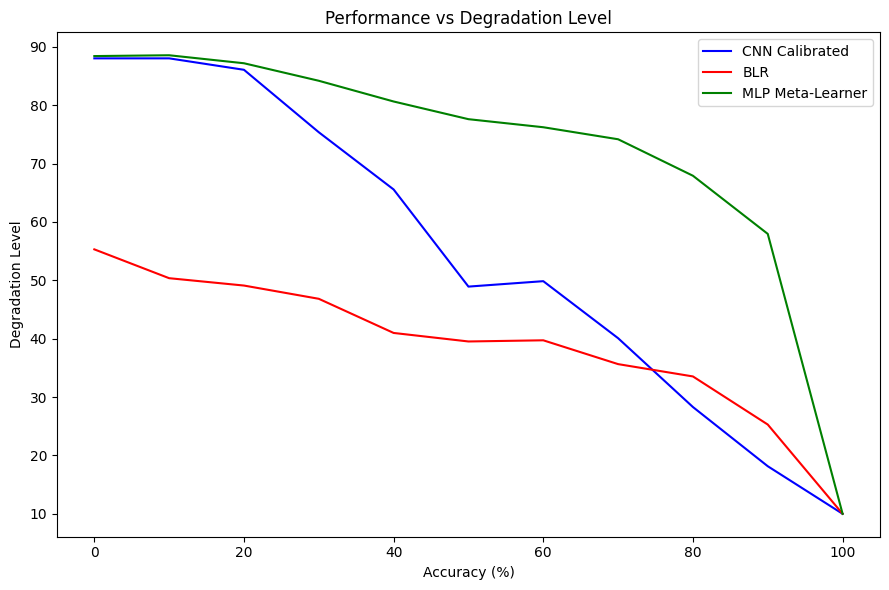

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(cnn_results_df['Degradation'], cnn_results_df['Accuracy (%)'], color='blue', label = 'CNN Calibrated')
plt.plot(blr_results_df['Degradation'], blr_results_df['Accuracy (%)'], color='red', label = 'BLR')
plt.plot(mlp_results_df['Degradation'], mlp_results_df['Acc'], color='green', label = 'MLP Meta-Learner')
plt.xlabel("Accuracy (%)")
plt.ylabel("Degradation Level")
plt.title("Performance vs Degradation Level")
plt.legend()
plt.tight_layout()
plt.show()


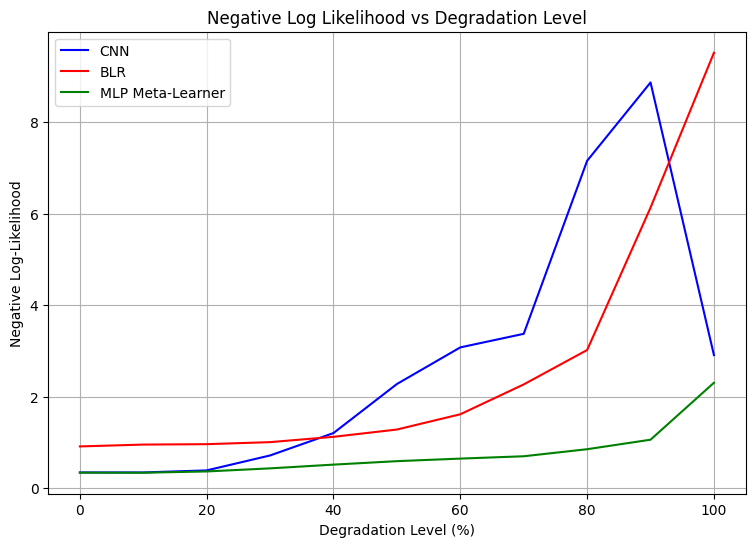

In [101]:
plt.figure(figsize=(9,6))
plt.plot(cnn_results_df["Degradation"], cnn_results_df["NLL"], color = 'blue', label="CNN")
plt.plot(blr_results_df["Degradation"], blr_results_df["NLL"], color = 'red', label="BLR")
plt.plot(mlp_results_df["Degradation"], mlp_results_df["NLL"], color = 'green', label="MLP Meta-Learner")
plt.xlabel("Degradation Level (%)")
plt.ylabel("Negative Log-Likelihood")
plt.title("Negative Log Likelihood vs Degradation Level")
plt.legend()
plt.grid(True)
plt.show()


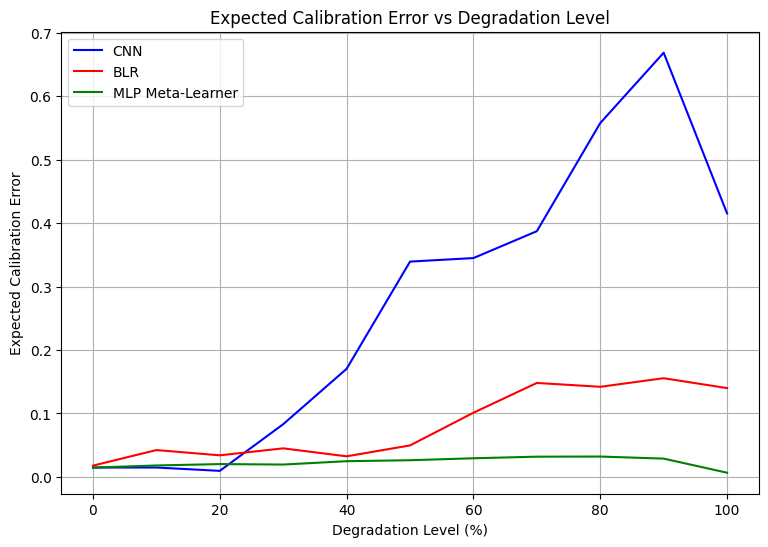

In [102]:
plt.figure(figsize=(9,6))
plt.plot(cnn_results_df["Degradation"], cnn_results_df["ECE"], color = 'blue', label="CNN")
plt.plot(blr_results_df["Degradation"], blr_results_df["ECE"], color = 'red', label="BLR")
plt.plot(mlp_results_df["Degradation"], mlp_results_df["ECE"], color = 'green', label="MLP Meta-Learner")
plt.xlabel("Degradation Level (%)")
plt.ylabel("Expected Calibration Error")
plt.title("Expected Calibration Error vs Degradation Level")
plt.legend()
plt.grid(True)
plt.show()


Results look very good, maybe too good to be true? Needs investigating: 

1. Data leakage between train/test

2. Overfitting to degradation level (memorise the patterns? as we keep the degradations the same over the different levels)

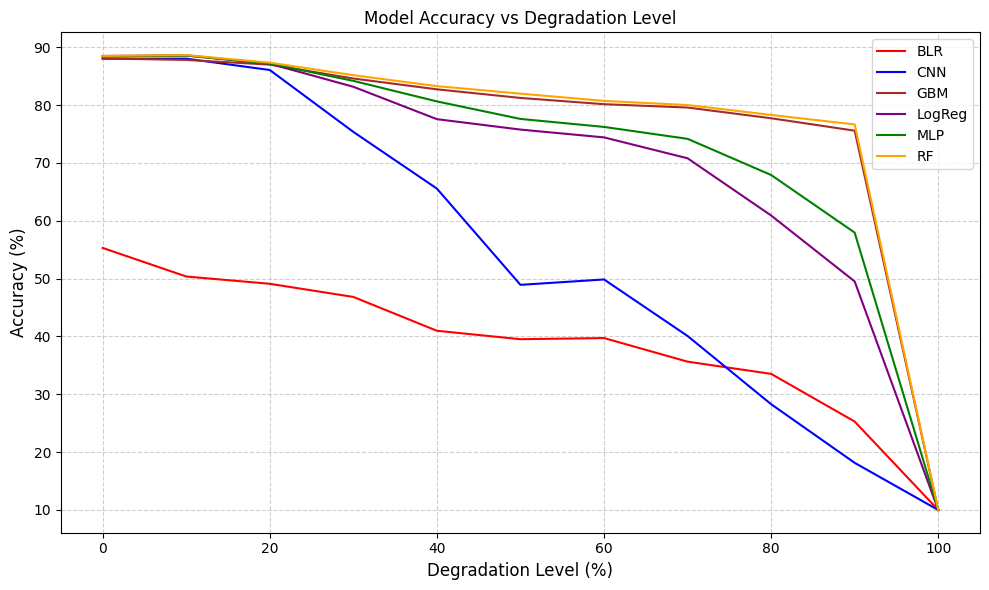

In [112]:
# Base models
cnn_results_df = pd.read_csv("cnn_results.csv") if "cnn_results.csv" in locals() else cnn_results_df
blr_results_df = pd.read_csv("blr_results.csv") if "blr_results.csv" in locals() else blr_results_df

# Meta-learners (LogReg, RF, GBM)
meta_results_df = pd.read_csv("meta_learners_per_level_results.csv")

# MLP
mlp_results_df = pd.read_csv("mlp_results.csv") if "mlp_results.csv" in locals() else mlp_results_df

# Standardise the names of columns 
cnn_results_df.rename(columns={"Accuracy (%)": "Acc"}, inplace=True)
blr_results_df.rename(columns={"Accuracy (%)": "Acc"}, inplace=True)

# Give model names 
cnn_results_df["Model"] = "CNN"
blr_results_df["Model"] = "BLR"
mlp_results_df["Model"] = "MLP"

# Combine 
combined_df = pd.concat([
    cnn_results_df[["Degradation", "Model", "Acc"]],
    blr_results_df[["Degradation", "Model", "Acc"]],
    meta_results_df[["Degradation", "Model", "Acc"]],
    mlp_results_df[["Degradation", "Model", "Acc"]]
], ignore_index=True)

# Plot
plt.figure(figsize=(10, 6))

colors = {
    "CNN": "blue",
    "BLR": "red",
    "LogReg": "purple",
    "RF": "orange",
    "GBM": "brown",
    "MLP": "green"}

for model_name, group in combined_df.groupby("Model"):
    plt.plot(group["Degradation"], group["Acc"],
             color=colors.get(model_name, None), label=model_name)

plt.xlabel("Degradation Level (%)", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Model Accuracy vs Degradation Level")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [108]:
print("Model expects:", model.n_features_in_)
print("X_test shape:", X_test.shape)
print("First 5 feature names used for training:", feature_cols[:5])


Model expects: 20
X_test shape: (10000, 40)
First 5 feature names used for training: ['cnn_full_class_0', 'cnn_full_class_1', 'cnn_full_class_2', 'cnn_full_class_3', 'cnn_full_class_4']


# Calculate AIC 

In [111]:
# Meta-learners used 
models = {
    "LogReg": LogisticRegression(max_iter=1000, multi_class="multinomial", C=0.1, penalty="l2"),
    "RF": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=0),
    "GBM": GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=0),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="tanh",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=200,
        random_state=0)}

def compute_aic(log_loss_value, n_params, n_samples):
    aic = 2 * n_params + 2 * n_samples * log_loss_value
    return aic

n_samples = len(y_test) 

# Approximate number of parameters for the nonlinear models
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

aic_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)

    if hasattr(model, "coef_"):
        n_params = model.coef_.size + model.intercept_.size
    elif hasattr(model, "feature_importances_"):
        n_params = len(model.feature_importances_)
    elif isinstance(model, MLPClassifier):
        # approximation for MLP 
        n_params = sum(w.size + b.size for w, b in zip(model.coefs_, model.intercepts_))
    else:
        # approximation for RF and GBM
        n_params = n_features * n_classes  
    
    # use NLL (log_loss)
    X_test_aligned = X_test[:, :model.n_features_in_]
    nll_test = log_loss(y_test, model.predict_proba(X_test_aligned), labels=np.arange(n_classes))
    aic = compute_aic(nll_test, n_params, n_samples)
    aic_results[name] = aic

print("Approximate AIC per model:")
for name, val in aic_results.items():
    print(f"{name:>10}: {val:.2f}")


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Approximate AIC per model:
    LogReg: 6749.99
        RF: 6392.52
       GBM: 5921.44
       MLP: 16043.34


/Users/ioannaioannidou/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Akaike Information Criterion (AIC) shows how well a model fits the data while it penalises for complexity. GBM has the lowest AIC saying that it fits best the data without being extremely complex. RF and Logistic Regression perform also quite well however are slighlty less accurate. MLP has the highest AIC showing that the model is too complex and most likely is overfitting. 